<a href="https://colab.research.google.com/github/wzheng1222/ALY6110/blob/main/ALY6110_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Prepare PySpark Session
# Install PySpark
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("BostonHousingAnalysis") \
    .getOrCreate()

# Verify the Spark session
spark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=fe3e71fbc997fc47b512594b18dad2937feb797fa2e2993fb9ff6d1c1c917849
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [8]:
# 2.Read 'BostonHousing.csv' dataset in PySpark
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("BostonHousingAnalysis") \
    .getOrCreate()

# Read the dataset
file_path = '/content/BostonHousing-1.csv'
boston_housing_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema and first few rows to verify
boston_housing_df.printSchema()
boston_housing_df.show(5)


root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4

In [9]:
# 3. Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv
from pyspark.ml.feature import VectorAssembler
# List all columns other than the target column 'medv'
feature_columns = boston_housing_df.columns[:-1]  # Assuming 'medv' is the last column

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data
assembled_data = assembler.transform(boston_housing_df)

# Show the assembled data
assembled_data.select("features", "medv").show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



In [10]:
# 4.Standardize features for principal component analysis
# Import necessary libraries for PySpark session and VectorAssembler
from pyspark.ml.feature import StandardScaler

# Read the dataset
file_path = '/content/BostonHousing-1.csv'
boston_housing_df = spark.read.csv(file_path, header=True, inferSchema=True)

# List all columns other than the target column 'medv'
feature_columns = boston_housing_df.columns[:-1]  # Assuming 'medv' is the last column

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data
assembled_data = assembler.transform(boston_housing_df)

# Initialize the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Fit and transform the data
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Show the scaled features
scaled_data.select("scaledFeatures", "medv").show(5)


+--------------------+----+
|      scaledFeatures|medv|
+--------------------+----+
|[-0.4193669292132...|24.0|
|[-0.4169266699640...|21.6|
|[-0.4169289951277...|34.7|
|[-0.4163384035610...|33.4|
|[-0.4120740534296...|36.2|
+--------------------+----+
only showing top 5 rows



In [11]:
# 5.Train model for two principal component analysis
# Import necessary libraries for PySpark session, VectorAssembler, StandardScaler, and PCA
from pyspark.ml.feature import PCA

# List all columns other than the target column 'medv'
feature_columns = boston_housing_df.columns[:-1]  # Assuming 'medv' is the last column

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data
assembled_data = assembler.transform(boston_housing_df)

# Initialize the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Fit and transform the data
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Initialize PCA with two principal components
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")

# Fit the PCA model
pca_model = pca.fit(scaled_data)

# Transform the data to get the principal components
pca_result = pca_model.transform(scaled_data)

# Show the principal components
pca_result.select("pcaFeatures", "medv").show(5)


+--------------------+----+
|         pcaFeatures|medv|
+--------------------+----+
|[2.09622303023858...|24.0|
|[1.45581098944742...|21.6|
|[2.07254655194818...|34.7|
|[2.60892175886434...|33.4|
|[2.45575477193107...|36.2|
+--------------------+----+
only showing top 5 rows



In [12]:
# 6.Collect distributed data in numpy array and then convert to pandas dataframe
import numpy as np
import pandas as pd

# Collect the PCA results to the driver node
pca_collected = pca_result.select("pcaFeatures", "medv").collect()

# Convert the collected data to a numpy array
# Use list comprehension to correctly extract PCA features and the target value
pca_array = np.array([(row['pcaFeatures'][0], row['pcaFeatures'][1], row['medv']) for row in pca_collected])

# Convert the numpy array to a pandas DataFrame
pca_df = pd.DataFrame(pca_array, columns=["PCA1", "PCA2", "medv"])

# Show the first few rows of the pandas DataFrame
pca_df.head()


,PCA1,PCA2,medv
0,2.096223,0.772348,24.0
1,1.455811,0.591400,21.6
2,2.072547,0.599047,34.7
3,2.608922,-0.006864,33.4
4,2.455755,0.097615,36.2


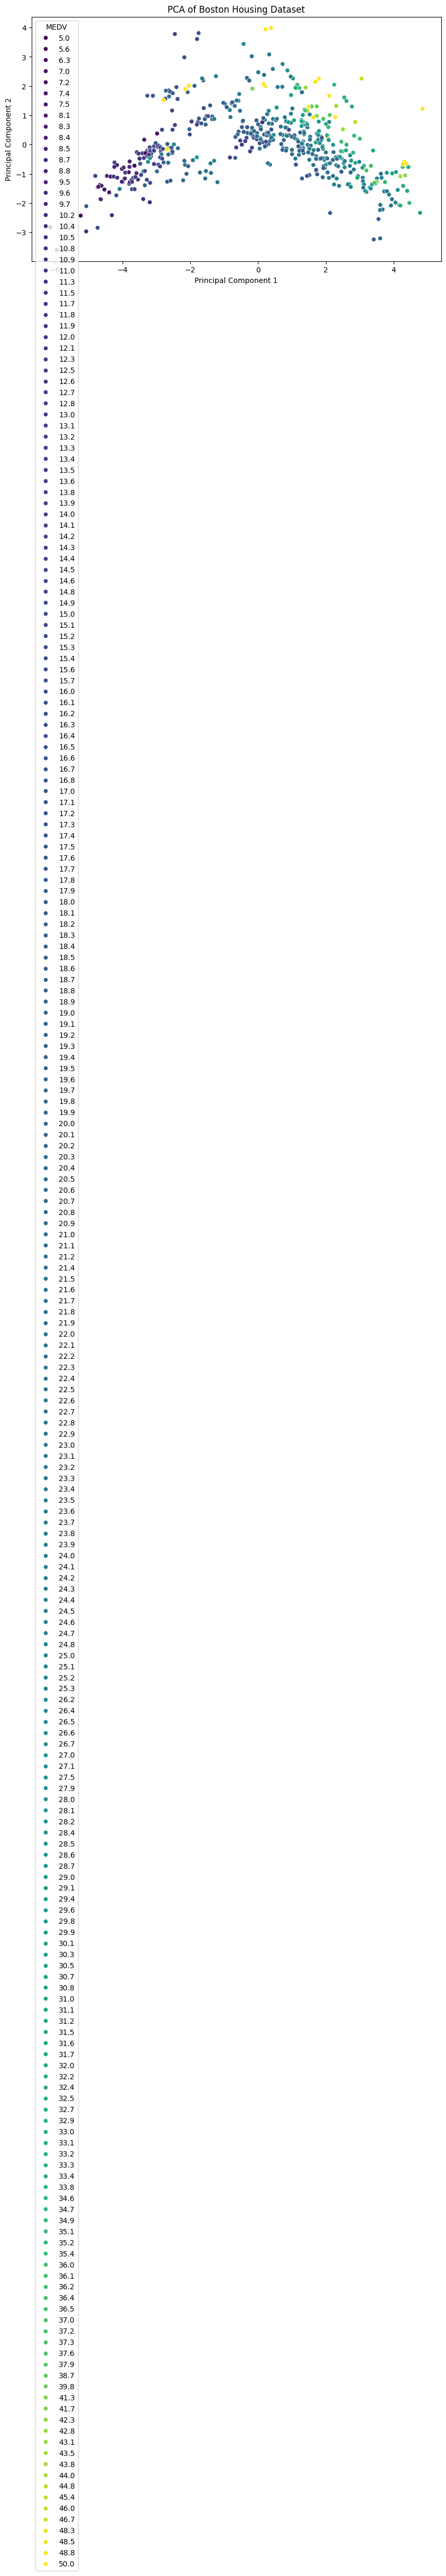

In [14]:
# 7.Plot two principal components
# Import necessary libraries for PySpark session, VectorAssembler, StandardScaler, PCA, numpy, pandas, and plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="medv", data=pca_df, palette="viridis", legend="full")
plt.title('PCA of Boston Housing Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='MEDV')
plt.show()


In [15]:
# 8. Vectorize features and target together for model development
# Convert pandas DataFrame back to Spark DataFrame for further processing
pca_spark_df = spark.createDataFrame(pca_df)

# Combine features and target into a single vector column
assembler = VectorAssembler(inputCols=["PCA1", "PCA2", "medv"], outputCol="features_with_target")

# Transform the data
final_data = assembler.transform(pca_spark_df)

# Show the final data
final_data.select("features_with_target").show(5, truncate=False)


+------------------------------------------------+
|features_with_target                            |
+------------------------------------------------+
|[2.096223030238583,0.7723484263420728,24.0]     |
|[1.4558109894474212,0.5913999518264818,21.6]    |
|[2.0725465519481854,0.5990465781004481,34.7]    |
|[2.6089217588643487,-0.0068638262975736246,33.4]|
|[2.4557547719310775,0.09761534604617053,36.2]   |
+------------------------------------------------+
only showing top 5 rows



In [16]:
# 9. Split dataset into training and testing dataset
# Split the dataset into training (80%) and testing (20%) sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Show the number of rows in each set to verify the split
print(f"Training Dataset Count: {train_data.count()}")
print(f"Testing Dataset Count: {test_data.count()}")


Training Dataset Count: 424
Testing Dataset Count: 82


In [17]:
# 10. Fit model for linear regression
# Initialize Linear Regression
lr = LinearRegression(featuresCol="features_with_target", labelCol="medv")

# Fit the model on the training data
lr_model = lr.fit(train_data)

# 11. Find out model coefficients and intercept
# Print the coefficients and intercept for linear regression
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# 12. Evaluate model for test dataset
# Evaluate the model on test data
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")
print(f"R-squared: {test_results.r2}")


Coefficients: [9.863330054883603e-15,1.0322131343228656e-14,0.9999999999999959]
Intercept: 9.871860989926702e-14
Root Mean Squared Error (RMSE): 2.6587703048072843e-14
R-squared: 1.0


+-------------------+------------------+----+--------------------+------------------+
|               PCA1|              PCA2|medv|features_with_target|        prediction|
+-------------------+------------------+----+--------------------+------------------+
|  -2.63260428015883|1.8489496939628263|11.8|[-2.6326042801588...|11.800000000000045|
|-2.4546638452665466| 3.780204506280668|13.4|[-2.4546638452665...|13.400000000000059|
|-2.3753496650003605|1.5587604271190918|15.6|[-2.3753496650003...|15.600000000000028|
| -1.960115672940611|0.7852774935328392|14.0|[-1.9601156729406...| 14.00000000000003|
|  -1.75476902348468| 3.812646323844729|17.0|[-1.7547690234846...|17.000000000000053|
+-------------------+------------------+----+--------------------+------------------+
only showing top 5 rows



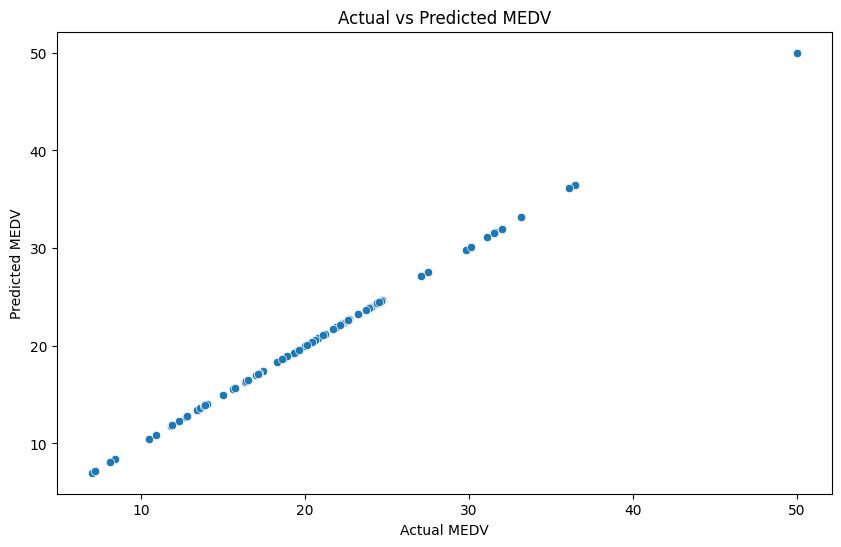

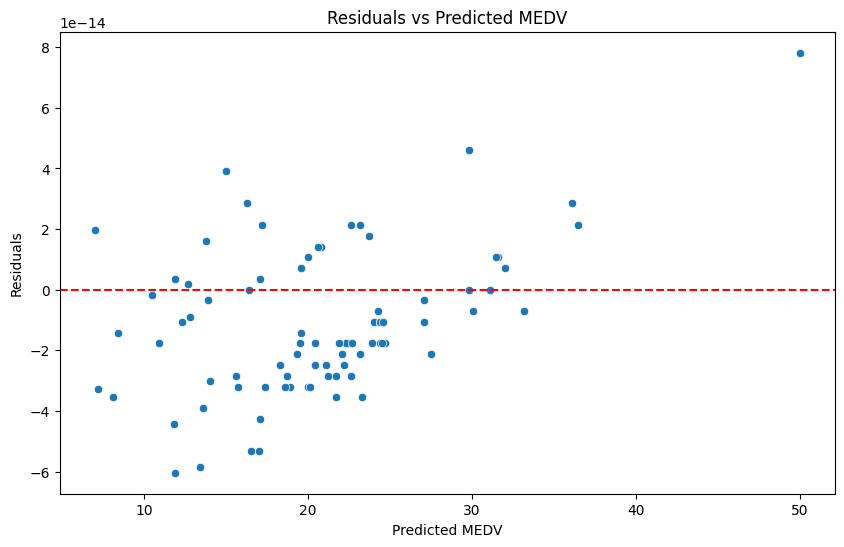

Mean Absolute Error (MAE): 2.1977000165506756e-14


In [18]:
# 13.Perform further analysis for better interpretation of model results.
# Examine the residuals, check for any patterns, and potentially visualize the predicted vs. actual values
# Predictions
predictions = lr_model.transform(test_data)
predictions.show(5)

# Convert predictions to Pandas DataFrame for further analysis
predictions_pd = predictions.select("medv", "prediction").toPandas()

# Calculate residuals
predictions_pd["residuals"] = predictions_pd["medv"] - predictions_pd["prediction"]

# Plot Predicted vs Actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x="medv", y="prediction", data=predictions_pd)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted MEDV")
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="residuals", data=predictions_pd)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted MEDV")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted MEDV")
plt.show()

# Calculate additional metrics
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")
